##### The purpose of this notebook

The motivation and the main idea of this notebook is outlined in details in [discussion topic](https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/158395).

**Version 9**: model EfficientNet B0, the notebook scores 0.914 on the public LB. The corresponding CV score is around 0.903.

**Version 10**: we experiment with the Shades of Gray algorithm using the same EfficientNet B0 model. See [this public kernel](https://www.kaggle.com/apacheco/shades-of-gray-color-constancy) and [this discussion topic](https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/161719) for more details. The result does not seem to be very encouraging (the CV drops to 0.897)

**Version 13**: we use the original images (no Shades of Gray pre-processing) and upgrade our model to EfficientNet B1. The number of epochs is reduced from 20 to 17 to meet the 3 hour limit requirement.

**Version 20**: we demonstrate how to implement the Advanced Hair Augmentation in TensorFlow using the same approach as before. The idea was suggested by [Roman](https://www.kaggle.com/nroman) in [this discussion topic](https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/159176). The TensorFlow implementation is discussed by me [here](https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/163909) and demonstrated in this [public notebook](https://www.kaggle.com/graf10a/siim-advanced-hair-augmentation-in-tensorflow) of mine. My prior experiments on Kaggle and Colab show that adding this augmentation increases the training time. To stay within the 3 hour limit we return to the EfficientNet B0 model and decrease the number of epochs to 10. So, don't expect a great score -- the purpose of the notebook is just to demonstate the implementation technique. I beleive that the training time can be optimized but this is the task we will save for the future. The images are pre-processed with the Shades of Gray algorithm (let's give it another chance -- it might surprise us!). See [this public kernel](https://www.kaggle.com/apacheco/shades-of-gray-color-constancy), [this discussion topic](https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/161719), and **Version 10** of this notebook for more information about the Shades of Gray algorithm.

In [1]:
colab=0
show_files=0
tstamp=0

In [2]:
if colab:
    from google.colab import drive
    drive.mount('/content/gdrive')

In [3]:
if (not colab)&show_files:
    import os
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output

### Loading libraries

In [4]:
!pip install -q efficientnet

In [5]:
import math
import pytz
import random
import numpy as np
import pandas as pd
import math, re, os, gc
import tensorflow as tf
from pathlib import Path
from datetime import datetime
from scipy.stats import rankdata
import efficientnet.tfkeras as efn
from matplotlib import pyplot as plt
from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score

print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

if not colab:
    from kaggle_datasets import KaggleDatasets

Tensorflow version 2.2.0


### Loading data

In [6]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

In [7]:
NAME='EffNB0_512'
NFOLDS=5
NBEST=2 # the number of best models to use for predictions
SEED=311
n_max=7     # the maximum number of hairs to augment

if colab:
    PATH=Path('/content/gdrive/My Drive/kaggle/input/siim-isic-melanoma-classification/') 
    train=pd.read_csv(PATH/'train.csv.zip')
else:
    PATH=Path('/kaggle/input/siim-isic-melanoma-classification/')
    train=pd.read_csv(PATH/'train.csv')

test=pd.read_csv(PATH/'test.csv')
sub=pd.read_csv(PATH/'sample_submission.csv')

seed_everything(SEED)

In [8]:
print(f"The shape of the training set is {train.shape}.")
print(f"The shape of the testing set is {test.shape}.")

The shape of the training set is (33126, 8).
The shape of the testing set is (10982, 5).


In [9]:
print(f"The columns in `train`:\n {list(train.columns)}.\n")
print(f"The columns in `test`:\n {list(test.columns)}.")

The columns in `train`:
 ['image_name', 'patient_id', 'sex', 'age_approx', 'anatom_site_general_challenge', 'diagnosis', 'benign_malignant', 'target'].

The columns in `test`:
 ['image_name', 'patient_id', 'sex', 'age_approx', 'anatom_site_general_challenge'].


In [10]:
train.head()

image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   

  diagnosis benign_malignant  target  
0   unknown           benign       0  
1   unknown           benign       0  
2     nevus           benign       0  
3   unknown           benign       0  
4   unknown           benign       0

In [11]:
test.head()

image_name  patient_id     sex  age_approx anatom_site_general_challenge
0  ISIC_0052060  IP_3579794    male        70.0                           NaN
1  ISIC_0052349  IP_7782715    male        40.0               lower extremity
2  ISIC_0058510  IP_7960270  female        55.0                         torso
3  ISIC_0073313  IP_6375035  female        50.0                         torso
4  ISIC_0073502  IP_0589375  female        45.0               lower extremity

### TPU or GPU detection

In [12]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment 
    # variable is set. On Kaggle this is always the case.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


### Data access

TPUs read data directly from Google Cloud Storage (GCS). If you are running this notebook on Kaggle, use `KaggleDatasets().get_gcs_path(dataset_name)` to determine the addresses of GCS buckets holding data for a given dataset. The name of the dataset is the name of the directory it is mounted in. Use `!ls /kaggle/input/` to list attached datasets.

Also, please note that the `KaggleDatasets()` utility does not work on Colab. So, if you are running this notebook on Colab copy and paste the addresses of all GCS buckets from your Kaggle notebook (note that these addresses change periodically, so you will have to update them every once in a while).

In [13]:
GCS_PATH={}

if colab:
    # WARNING: Update the GCS bucket addresses!
    GCS_PATH['train']='gs://kds-4169ce1e5a624d4b5bd866480682658f2063b18c5cf995cd3316a7e9'
    GCS_PATH['test']='gs://kds-147ff1400c195e2f8c7b01492e04fd2769e0305e9ef6c01afc9c5870'
    GCS_PATH['hairs']='gs://kds-9e567a6e6d1255950cf43b26db187228f633ac7ec6bb6dcf70c1b511'
else:
    GCS_PATH['train']=KaggleDatasets().get_gcs_path('siim-tfrec-cc-512-train')
    GCS_PATH['test']=KaggleDatasets().get_gcs_path('siim-tfrec-cc-512-test')
    # Roman's images of hairs
    GCS_PATH['hairs']=KaggleDatasets().get_gcs_path('melanoma-hairs')

print(GCS_PATH['train'])
print(GCS_PATH['test'])
print(GCS_PATH['hairs'])

gs://kds-40c1c65209bb61af547232c5970984486d942a8c9cc7a13478d2ebcb
gs://kds-23f84f2d8792574f7394a6c8e34ef4d7b4cb7925f538bd454310db4a
gs://kds-b96c0c7e4ff91ff29efa78ddc644279109191cfd77cf67a6b9649673


### Configuration

In [14]:
%%time

IMAGE_SIZE = [512, 512] # At this size, a GPU will run out of memory. Use the TPU.
                          # For GPU training, please select 224 x 224 px image size.
EPOCHS=10
BATCH_SIZE = 8 * strategy.num_replicas_in_sync

CLASSES = ['benign', 'malignant']

CPU times: user 13 µs, sys: 4 µs, total: 17 µs
Wall time: 22.9 µs


Reading and storing the .tfrec file names for train, validation, and test sets.

In [15]:
ALL_TRAIN=tf.io.gfile.glob(GCS_PATH['train'] + '/*.tfrec')

VAL_FNAMES={}
for fn in range(1, NFOLDS+1):
    VAL_FNAMES[f"fold_{fn}"]=[path for path in ALL_TRAIN if f"fold_{fn}" in path]    
    print("Fold", f'{fn}:', len(VAL_FNAMES[f'fold_{fn}']), "elements in total.")
    
TRAIN_FNAMES={f'fold_{i}': list(set(ALL_TRAIN)-set(VAL_FNAMES[f'fold_{i}']))
              for i in range(1, NFOLDS+1)}

TEST_FNAMES = tf.io.gfile.glob(GCS_PATH['test'] + '/*.tfrec')

# Roman's images of hairs
hair_images=tf.io.gfile.glob(GCS_PATH['hairs'] + '/*.png')

Fold 1: 4 elements in total.
Fold 2: 4 elements in total.
Fold 3: 4 elements in total.
Fold 4: 4 elements in total.
Fold 5: 4 elements in total.


In [16]:
len(ALL_TRAIN), len(TEST_FNAMES), len(TRAIN_FNAMES), len(VAL_FNAMES), len(hair_images)

(20, 20, 5, 5, 5)

In [17]:
VAL_FNAMES

{'fold_1': ['gs://kds-40c1c65209bb61af547232c5970984486d942a8c9cc7a13478d2ebcb/fold_1_00-1656.tfrec',
  'gs://kds-40c1c65209bb61af547232c5970984486d942a8c9cc7a13478d2ebcb/fold_1_01-1656.tfrec',
  'gs://kds-40c1c65209bb61af547232c5970984486d942a8c9cc7a13478d2ebcb/fold_1_02-1656.tfrec',
  'gs://kds-40c1c65209bb61af547232c5970984486d942a8c9cc7a13478d2ebcb/fold_1_03-1656.tfrec'],
 'fold_2': ['gs://kds-40c1c65209bb61af547232c5970984486d942a8c9cc7a13478d2ebcb/fold_2_00-1658.tfrec',
  'gs://kds-40c1c65209bb61af547232c5970984486d942a8c9cc7a13478d2ebcb/fold_2_01-1658.tfrec',
  'gs://kds-40c1c65209bb61af547232c5970984486d942a8c9cc7a13478d2ebcb/fold_2_02-1658.tfrec',
  'gs://kds-40c1c65209bb61af547232c5970984486d942a8c9cc7a13478d2ebcb/fold_2_03-1656.tfrec'],
 'fold_3': ['gs://kds-40c1c65209bb61af547232c5970984486d942a8c9cc7a13478d2ebcb/fold_3_00-1659.tfrec',
  'gs://kds-40c1c65209bb61af547232c5970984486d942a8c9cc7a13478d2ebcb/fold_3_01-1659.tfrec',
  'gs://kds-40c1c65209bb61af547232c5970984486d94

In [18]:
TRAIN_FNAMES

{'fold_1': ['gs://kds-40c1c65209bb61af547232c5970984486d942a8c9cc7a13478d2ebcb/fold_2_02-1658.tfrec',
  'gs://kds-40c1c65209bb61af547232c5970984486d942a8c9cc7a13478d2ebcb/fold_5_03-1654.tfrec',
  'gs://kds-40c1c65209bb61af547232c5970984486d942a8c9cc7a13478d2ebcb/fold_4_01-1656.tfrec',
  'gs://kds-40c1c65209bb61af547232c5970984486d942a8c9cc7a13478d2ebcb/fold_3_01-1659.tfrec',
  'gs://kds-40c1c65209bb61af547232c5970984486d942a8c9cc7a13478d2ebcb/fold_5_01-1654.tfrec',
  'gs://kds-40c1c65209bb61af547232c5970984486d942a8c9cc7a13478d2ebcb/fold_2_03-1656.tfrec',
  'gs://kds-40c1c65209bb61af547232c5970984486d942a8c9cc7a13478d2ebcb/fold_4_03-1654.tfrec',
  'gs://kds-40c1c65209bb61af547232c5970984486d942a8c9cc7a13478d2ebcb/fold_2_01-1658.tfrec',
  'gs://kds-40c1c65209bb61af547232c5970984486d942a8c9cc7a13478d2ebcb/fold_3_02-1659.tfrec',
  'gs://kds-40c1c65209bb61af547232c5970984486d942a8c9cc7a13478d2ebcb/fold_3_00-1659.tfrec',
  'gs://kds-40c1c65209bb61af547232c5970984486d942a8c9cc7a13478d2ebcb/f

In [19]:
ALL_TRAIN

['gs://kds-40c1c65209bb61af547232c5970984486d942a8c9cc7a13478d2ebcb/fold_1_00-1656.tfrec',
 'gs://kds-40c1c65209bb61af547232c5970984486d942a8c9cc7a13478d2ebcb/fold_1_01-1656.tfrec',
 'gs://kds-40c1c65209bb61af547232c5970984486d942a8c9cc7a13478d2ebcb/fold_1_02-1656.tfrec',
 'gs://kds-40c1c65209bb61af547232c5970984486d942a8c9cc7a13478d2ebcb/fold_1_03-1656.tfrec',
 'gs://kds-40c1c65209bb61af547232c5970984486d942a8c9cc7a13478d2ebcb/fold_2_00-1658.tfrec',
 'gs://kds-40c1c65209bb61af547232c5970984486d942a8c9cc7a13478d2ebcb/fold_2_01-1658.tfrec',
 'gs://kds-40c1c65209bb61af547232c5970984486d942a8c9cc7a13478d2ebcb/fold_2_02-1658.tfrec',
 'gs://kds-40c1c65209bb61af547232c5970984486d942a8c9cc7a13478d2ebcb/fold_2_03-1656.tfrec',
 'gs://kds-40c1c65209bb61af547232c5970984486d942a8c9cc7a13478d2ebcb/fold_3_00-1659.tfrec',
 'gs://kds-40c1c65209bb61af547232c5970984486d942a8c9cc7a13478d2ebcb/fold_3_01-1659.tfrec',
 'gs://kds-40c1c65209bb61af547232c5970984486d942a8c9cc7a13478d2ebcb/fold_3_02-1659.tfrec',

In [20]:
hair_images

['gs://kds-b96c0c7e4ff91ff29efa78ddc644279109191cfd77cf67a6b9649673/1.png',
 'gs://kds-b96c0c7e4ff91ff29efa78ddc644279109191cfd77cf67a6b9649673/2.png',
 'gs://kds-b96c0c7e4ff91ff29efa78ddc644279109191cfd77cf67a6b9649673/3.png',
 'gs://kds-b96c0c7e4ff91ff29efa78ddc644279109191cfd77cf67a6b9649673/4.png',
 'gs://kds-b96c0c7e4ff91ff29efa78ddc644279109191cfd77cf67a6b9649673/5.png']

In [21]:
def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, 
    # i.e. test10-687.tfrec = 687 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    
    return np.sum(n)

In [22]:
%%time

N_TRAIN_IMGS = {f'fold_{i}': count_data_items(TRAIN_FNAMES[f'fold_{i}'])
                for i in range(1, NFOLDS+1)}

N_VAL_IMGS = {f'fold_{i}': count_data_items(VAL_FNAMES[f'fold_{i}'])
              for i in range(1, NFOLDS+1)}

N_TEST_IMGS = count_data_items(TEST_FNAMES)

STEPS_PER_EPOCH = {f'fold_{i}': N_TRAIN_IMGS[f'fold_{i}'] // BATCH_SIZE
                   for i in range(1, NFOLDS+1)}

print("="*75)

print(f"The number of unlabeled test image is {N_TEST_IMGS}. It is common for all folds.")

for i in range(1, NFOLDS+1):
    print("="*75)
    print(f"Fold {i}: {N_TRAIN_IMGS[f'fold_{i}']} training and {N_VAL_IMGS[f'fold_{i}']} validation images.")
print("="*75)

The number of unlabeled test image is 10982. It is common for all folds.
Fold 1: 26502 training and 6624 validation images.
Fold 2: 26496 training and 6630 validation images.
Fold 3: 26492 training and 6634 validation images.
Fold 4: 26504 training and 6622 validation images.
Fold 5: 26510 training and 6616 validation images.
CPU times: user 1.66 ms, sys: 18 µs, total: 1.68 ms
Wall time: 1.42 ms


### Datasets

Below are the functions that we will be using to read and process the data from the `.tfrec` files. 

In [23]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    # convert image to floats in [0, 1] range
    image = tf.cast(image, tf.float32) / 255.0 
    # explicit size needed for TPU
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    
    return image

In [24]:
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        # tf.string means bytestring
        # shape [] means single element
        ################################
        # bytestring features
        "image": tf.io.FixedLenFeature([], tf.string), 
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "patient_id": tf.io.FixedLenFeature([], tf.string),
        "benign_malignant": tf.io.FixedLenFeature([], tf.string),
        # integer features
        "age": tf.io.FixedLenFeature([], tf.int64),
        "sex_female": tf.io.FixedLenFeature([], tf.int64),        
        "sex_male": tf.io.FixedLenFeature([], tf.int64),
        "sex_unknown": tf.io.FixedLenFeature([], tf.int64),
        "site_head/neck": tf.io.FixedLenFeature([], tf.int64),
        "site_lower extremity": tf.io.FixedLenFeature([], tf.int64),
        "site_oral/genital": tf.io.FixedLenFeature([], tf.int64),
        "site_palms/soles": tf.io.FixedLenFeature([], tf.int64),
        "site_torso": tf.io.FixedLenFeature([], tf.int64),
        "site_unknown": tf.io.FixedLenFeature([], tf.int64),
        "site_upper extremity": tf.io.FixedLenFeature([], tf.int64),
        "height": tf.io.FixedLenFeature([], tf.int64),
        "width": tf.io.FixedLenFeature([], tf.int64),
        "target": tf.io.FixedLenFeature([], tf.int64), 
        # float features
        "age_scaled": tf.io.FixedLenFeature([], tf.float32),
    }

    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    # image data
    image = decode_image(example['image']) 
    data={}
    # bytestring features
    data['image_name']=image_name=tf.cast(example['image_name'], tf.string)
    data['patient_id']=tf.cast(example['patient_id'], tf.string)
    # integer features
    data['age']=tf.cast(example['age'], tf.int32)
    data['sex_female']=tf.cast(example['sex_female'], tf.int32)
    data['sex_male']=tf.cast(example['sex_male'], tf.int32)
    data['sex_unknown']=tf.cast(example['sex_unknown'], tf.int32)
    data['site_head/neck']=tf.cast(example['site_head/neck'], tf.int32)
    data['site_lower extremity']=tf.cast(example['site_lower extremity'], tf.int32)
    data['site_oral/genital']=tf.cast(example['site_oral/genital'], tf.int32)
    data['site_palms/soles']=tf.cast(example['site_palms/soles'], tf.int32)
    data['site_torso']=tf.cast(example['site_torso'], tf.int32)
    data['site_unknown']=tf.cast(example['site_unknown'], tf.int32)
    data['site_upper extremity']=tf.cast(example['site_upper extremity'], tf.int32)
#     data['height']=tf.cast(example['height'], tf.int32)
#     data['width']=tf.cast(example['width'], tf.int32)
    # float features
    data['age_scaled']=tf.cast(example['age_scaled'], tf.float32)
    # target (integer)
    label=tf.cast(example['target'], tf.int32)
     # target (string)
    label_name=tf.cast(example['benign_malignant'], tf.string)

    return image, label, data, label_name

In [25]:
def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        # tf.string means bytestring
        # shape [] means single element
        ################################
        # bytestring features
        "image": tf.io.FixedLenFeature([], tf.string), 
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "patient_id": tf.io.FixedLenFeature([], tf.string),
        # integer features
        "age": tf.io.FixedLenFeature([], tf.int64),
        "sex_female": tf.io.FixedLenFeature([], tf.int64),        
        "sex_male": tf.io.FixedLenFeature([], tf.int64),
        "sex_unknown": tf.io.FixedLenFeature([], tf.int64),
        "site_head/neck": tf.io.FixedLenFeature([], tf.int64),
        "site_lower extremity": tf.io.FixedLenFeature([], tf.int64),
        "site_oral/genital": tf.io.FixedLenFeature([], tf.int64),
        "site_palms/soles": tf.io.FixedLenFeature([], tf.int64),
        "site_torso": tf.io.FixedLenFeature([], tf.int64),
        "site_unknown": tf.io.FixedLenFeature([], tf.int64),
        "site_upper extremity": tf.io.FixedLenFeature([], tf.int64),
        "height": tf.io.FixedLenFeature([], tf.int64),
        "width": tf.io.FixedLenFeature([], tf.int64), 
        # float features
        "age_scaled": tf.io.FixedLenFeature([], tf.float32),
    }

    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    # image data
    image = decode_image(example['image']) 
    data={}
    # bytestring features
    data['image_name']=image_name=tf.cast(example['image_name'], tf.string)
    data['patient_id']=tf.cast(example['patient_id'], tf.string)
    # integer features
    data['age']=tf.cast(example['age'], tf.int32)
    data['sex_female']=tf.cast(example['sex_female'], tf.int32)
    data['sex_male']=tf.cast(example['sex_male'], tf.int32)
    data['sex_unknown']=tf.cast(example['sex_unknown'], tf.int32)
    data['site_head/neck']=tf.cast(example['site_head/neck'], tf.int32)
    data['site_lower extremity']=tf.cast(example['site_lower extremity'], tf.int32)
    data['site_oral/genital']=tf.cast(example['site_oral/genital'], tf.int32)
    data['site_palms/soles']=tf.cast(example['site_palms/soles'], tf.int32)
    data['site_torso']=tf.cast(example['site_torso'], tf.int32)
    data['site_unknown']=tf.cast(example['site_unknown'], tf.int32)
    data['site_upper extremity']=tf.cast(example['site_upper extremity'], tf.int32)
#     data['height']=tf.cast(example['height'], tf.int32)
#     data['width']=tf.cast(example['width'], tf.int32)
    # float features
    data['age_scaled']=tf.cast(example['age_scaled'], tf.float32)

    return image, data

In [26]:
def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files 
    # at once and disregarding data order. Order does not matter since we will 
    # be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        # disable order, increase speed
        ignore_order.experimental_deterministic = False

    # automatically interleaves reads from multiple files
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.with_options(ignore_order)
    # returns a dataset of (image, label) pairs if labeled=True 
    # or (image, id) pairs if labeled=False
    dataset = dataset.map(read_labeled_tfrecord if labeled 
                          else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    
    return dataset

Let's take a quick look at some training and validation examples:

In [27]:
%%time

training_dataset = load_dataset(TRAIN_FNAMES['fold_2'])

print("Example of the training data:")
for image, label, data, label_name in training_dataset.take(1):
    print("The image batch size:", image.numpy().shape)
    print("Label:", label.numpy())
    print("Label name:", label_name.numpy())
    print("Age:", data['age'].numpy())
    print("Age (scaled):", data['age_scaled'].numpy())

Example of the training data:
The image batch size: (512, 512, 3)
Label: 0
Label name: b'benign'
Age: 45
Age (scaled): -0.26955867
CPU times: user 1.12 s, sys: 24.9 ms, total: 1.15 s
Wall time: 4.72 s


In [28]:
%%time

validation_dataset = load_dataset(VAL_FNAMES['fold_2'])

print("Examples of the validation data:")
for image, label, data, label_name in validation_dataset.take(1):
    print("The image batch size:", image.numpy().shape)
    print("Label:", label.numpy())
    print("Label name:", label_name.numpy())
    print("Age:", data['age'].numpy())
    print("Age (scaled):", data['age_scaled'].numpy())

Examples of the validation data:
The image batch size: (512, 512, 3)
Label: 0
Label name: b'benign'
Age: 55
Age (scaled): 0.42655516
CPU times: user 68.7 ms, sys: 25.6 ms, total: 94.3 ms
Wall time: 2.78 s


Here is a function for generagting a test dataset.

In [29]:
def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FNAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    # prefetch next batch while training (autotune prefetch buffer size)
    dataset = dataset.prefetch(AUTO)
    
    return dataset

And here are some quick examples of the test data:

In [30]:
%%time

test_dataset = get_test_dataset()

print("Examples of the test data:")
for image, data in test_dataset.take(1):
    print("The image batch size:", image.numpy().shape)
    print("Ages, 5 examples:", data['age'].numpy()[:5])
    print("Age (scaled), 5 examples:", data['age_scaled'].numpy()[:5])
#     print("Height, 5 examples:", data['height'].numpy()[:5])
#     print("Width, 5 examples:", data['width'].numpy()[:5])

Examples of the test data:
The image batch size: (64, 512, 512, 3)
Ages, 5 examples: [70 40 55 50 45]
Age (scaled), 5 examples: [ 1.4707259  -0.6176156   0.42655516  0.07849825 -0.26955867]
CPU times: user 912 ms, sys: 488 ms, total: 1.4 s
Wall time: 3.8 s


### Model

Learning rate schedule: 5e-06 to 5.8e-05 to 5.8e-05


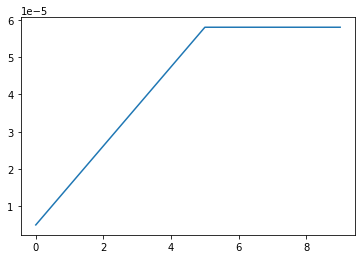

In [31]:
# Learning rate schedule for TPU, GPU and CPU.
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.

LR_START = 0.000005#0.00001
LR_MAX = 0.00000725 * strategy.num_replicas_in_sync
LR_MIN = 0.000005
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 4
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [32]:
train['target'].values
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train['target'].values),
                                                  y=train['target'].values,
                                                 )

class_weights = {i : class_weights[i] for i in range(len(class_weights))}

print(class_weights)

{0: 0.5089730194825149, 1: 28.361301369863014}


In [33]:
tab_feats=['age_scaled',
           'sex_female', 
           'sex_male', 
           'sex_unknown', 
           'site_head/neck', 
           'site_lower extremity', 
           'site_oral/genital',
           'site_palms/soles',
           'site_torso',
           'site_unknown',
           'site_upper extremity',
#            'height',
#            'width',
          ]

N_TAB_FEATS=len(tab_feats)

print(f"The number of tabular features is {N_TAB_FEATS}.")

The number of tabular features is 11.


In [34]:
%time

def get_model():
    with strategy.scope():
        pretrained_model = efn.EfficientNetB0(input_shape=(*IMAGE_SIZE, 3),
                                              weights='imagenet',
                                              include_top=False
                                             )
        # False = transfer learning, True = fine-tuning
        pretrained_model.trainable = True#False 

        inp1 = tf.keras.layers.Input(shape=(*IMAGE_SIZE, 3), name='inp1')
        inp2 = tf.keras.layers.Input(shape=(N_TAB_FEATS), name='inp2')
        
        # BUILD MODEL HERE
        
        x=pretrained_model(inp1)
        x=tf.keras.layers.GlobalAveragePooling2D()(x)
        x=tf.keras.layers.Dense(512, 
                                kernel_regularizer=tf.keras.regularizers.l2(l=0.01),
                                activation='relu')(x)
        x=tf.keras.layers.Dropout(0.2)(x)
        x=tf.keras.layers.Dense(256, 
                                kernel_regularizer=tf.keras.regularizers.l2(l=0.01),
                                activation='relu')(x)
        x=tf.keras.layers.Dropout(0.2)(x)
        x=tf.keras.layers.Dense(128, 
                                kernel_regularizer=tf.keras.regularizers.l2(l=0.01),
                                activation='relu')(x)
        x=tf.keras.layers.Dropout(0.2)(x)
        x=tf.keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(l=0.01),
                                activation='relu')(x)
        x=tf.keras.layers.Dropout(0.2)(x)
        
        y=tf.keras.layers.Dense(100, 
                                kernel_regularizer=tf.keras.regularizers.l2(l=0.01),
                                activation='relu')(inp2)
        
        concat=tf.keras.layers.concatenate([y, x])
        
        output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(concat)
        
        model = tf.keras.models.Model(inputs=[inp1,inp2], outputs=[output])
    
        model.compile(
        optimizer='adam',
        loss = 'binary_crossentropy',
        metrics=[tf.keras.metrics.AUC()],
        )
        
        return model

CPU times: user 6 µs, sys: 2 µs, total: 8 µs
Wall time: 13.1 µs


In [35]:
%%time

model=get_model()
model.summary()

16809984/16804768 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp1 (InputLayer)               [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
efficientnet-b0 (Model)         (None, 16, 16, 1280) 4049564     inp1[0][0]                       
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 1280)         0           efficientnet-b0[1][0]            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          655872      global_average_pooling2d[0][0]   
_____________________________

In [36]:
del model
gc.collect()

818

In [37]:
if colab:
    
    SAVE_FOLDER=NAME
    
    if tstamp:
        time_zone = pytz.timezone('America/Chicago')
        current_datetime = datetime.now(time_zone)
        ts=current_datetime.strftime("%m%d%H%M%S")
        SAVE_FOLDER+='_'+ts
        
    SAVE_FOLDER=PATH/SAVE_FOLDER
    if not os.path.exists(SAVE_FOLDER):
        os.mkdir(SAVE_FOLDER)

else:
    SAVE_FOLDER=Path('/kaggle/working')

In [38]:
class save_best_n(tf.keras.callbacks.Callback):
    def __init__(self, fn, model):
        self.fn = fn
        self.model = model

    def on_epoch_end(self, epoch, logs=None):
        
        if (epoch>0):
            score=logs.get("val_auc")
        else:
            score=-1
      
        if (score > best_score[fold_num].min()):
          
            idx_min=np.argmin(best_score[fold_num])

            best_score[fold_num][idx_min]=score
            best_epoch[fold_num][idx_min]=epoch+1

            path_best_model=f'best_model_fold_{self.fn}_{idx_min}.hdf5'
            self.model.save(SAVE_FOLDER/path_best_model)
            ############# WARNING: ##################################
            # Make sure you have enough space to store your models. 
            # Remember that Kaggle allows you save not more than 5 Gb
            # to disk. It should not be a problem for EfficientNet B0 
            # or B3 but it is not going to work for B7. I am saving my
            # models to Google Drive where I have plenty of space.

### Setting up the train/validation data pipeline with augmentation

In [39]:
def setup_input(image, label, data, label_name):
    
    tab_data=[tf.cast(data[tfeat], dtype=tf.float32) for tfeat in tab_feats]
    
    tabular=tf.stack(tab_data)
    
    return {'inp1': image, 'inp2':  tabular}, label

In [40]:
def data_augment(data, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement 
    # in the next function (below), this happens essentially for free on TPU. 
    # Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(data['inp1'])
    image = tf.image.random_flip_up_down(image)
    
    return {'inp1': image, 'inp2':  data['inp2']}, label

In [41]:
hair_images_tf=tf.convert_to_tensor(hair_images)
scale=tf.cast(IMAGE_SIZE[0]/256, dtype=tf.int32)

In [42]:
def hair_aug(data, label):
    # Copy the input image, so it won't be changed
    img=tf.identity(data['inp1']) 
    # Randomly choose the number of hairs to augment (up to n_max)
    n_hairs = tf.random.uniform(shape=[], maxval=tf.constant(n_max)+1, 
                                dtype=tf.int32)
    
    im_height=tf.shape(img)[1]
    im_width=tf.shape(img)[0]
    
    if n_hairs == 0:
        return data, label

    for _ in tf.range(n_hairs):

        # Read a random hair image
        i=tf.random.uniform(shape=[], maxval=tf.shape(hair_images_tf)[0], 
                            dtype=tf.int32)
        fname=hair_images_tf[i]

        bits = tf.io.read_file(fname)
        hair = tf.image.decode_jpeg(bits)
        
        # Rescale the hair image to the right size (256 -- original size)
        new_width=scale*tf.shape(hair)[1]
        new_height=scale*tf.shape(hair)[0]
        hair = tf.image.resize(hair, [new_height, new_width])

        
        # Random flips of the hair image
        hair = tf.image.random_flip_left_right(hair)
        hair = tf.image.random_flip_up_down(hair)
        # Random number of 90 degree rotations
        n_rot=tf.random.uniform(shape=[], maxval=4,
                                dtype=tf.int32)
        hair = tf.image.rot90(hair, k=n_rot)
        
        h_height=tf.shape(hair)[0]
        h_width=tf.shape(hair)[1]
        
        roi_h0 = tf.random.uniform(shape=[], maxval=im_height - h_height + 1, 
                                    dtype=tf.int32)
        roi_w0 = tf.random.uniform(shape=[], maxval=im_width - h_width + 1, 
                                    dtype=tf.int32)


        roi = img[roi_h0:(roi_h0 + h_height), roi_w0:(roi_w0 + h_width)]  

        # Convert the hair image to grayscale 
        # (slice to remove the trainsparency channel)
        hair2gray = tf.image.rgb_to_grayscale(hair[:, :, :3])

        mask=hair2gray>10

        img_bg = tf.multiply(roi, tf.cast(tf.image.grayscale_to_rgb(~mask),
                                          dtype=tf.float32))
        hair_fg = tf.multiply(tf.cast(hair[:, :, :3], dtype=tf.int32),
                              tf.cast(tf.image.grayscale_to_rgb(mask), 
                                      dtype=tf.int32
                                      )
                             )

        dst = tf.add(img_bg, tf.cast(hair_fg, dtype=tf.float32)/255)

        paddings = tf.stack([
            [roi_h0, im_height-(roi_h0 + h_height)], 
            [roi_w0, im_width-(roi_w0 + h_width)],
            [0, 0]
        ])

        # Pad dst with zeros to make it the same shape as image.
        dst_padded=tf.pad(dst, paddings, "CONSTANT")
        # Create a boolean mask with zeros at the pixels of
        # the augmentation segment and ones everywhere else
        mask_img=tf.pad(tf.ones_like(dst), paddings, "CONSTANT")
        mask_img=~tf.cast(mask_img, dtype=tf.bool)
        # Make a hole in the original image at the location
        # of the augmentation segment
        img_hole=tf.multiply(img, tf.cast(mask_img, dtype=tf.float32))
        # Inserting the augmentation segment in place of the hole
        img=tf.add(img_hole, dst_padded)
        
    return {'inp1': img, 'inp2':  data['inp2']}, label

In [43]:
def get_training_dataset(dataset):
    # horizontal and vertical random flips
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    # advanced hair augmentation
    dataset = dataset.map(hair_aug, num_parallel_calls=AUTO)
    # the training dataset must repeat for several epochs
    dataset = dataset.repeat()
    dataset = dataset.shuffle(512)
    dataset = dataset.batch(BATCH_SIZE)
    # prefetch next batch while training (autotune prefetch buffer size)
    dataset = dataset.prefetch(AUTO)
    
    return dataset

In [44]:
def get_validation_dataset(dataset):
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    # prefetch next batch while training (autotune prefetch buffer size)
    dataset = dataset.prefetch(AUTO)
    
    return dataset

### Visualization utilities

In [45]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

In [46]:
def batch_to_numpy_images_and_labels(databatch, ds='train'):
    if ds=='train':
        data, labels = databatch
        numpy_images = data['inp1'].numpy()
        numpy_labels = labels.numpy()
    else:
        data = databatch
        numpy_images = data['inp1'].numpy()
        numpy_labels = [None for _ in enumerate(numpy_images)]

    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

In [47]:
def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" 
                                if not correct else '', 
                                CLASSES[correct_label] if not correct else ''), correct

In [48]:
def display_one_image(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), 
                  color='red' if red else 'black', fontdict={'verticalalignment':'center'}, 
                  pad=int(titlesize/1.5)
                 )
    return (subplot[0], subplot[1], subplot[2]+1)

In [49]:
def display_batch_of_images(databatch, predictions=None, ds='train'):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch, ds=ds)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does  
    # not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        # magic formula tested to work from 1x1 to 10x10 images
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3
        subplot = display_one_image(image, title, subplot, 
                                     not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

### Dataset visualizations

In [50]:
# Peek at training data

training_dataset = training_dataset.map(setup_input, num_parallel_calls=AUTO)   
training_dataset = get_training_dataset(training_dataset)
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)

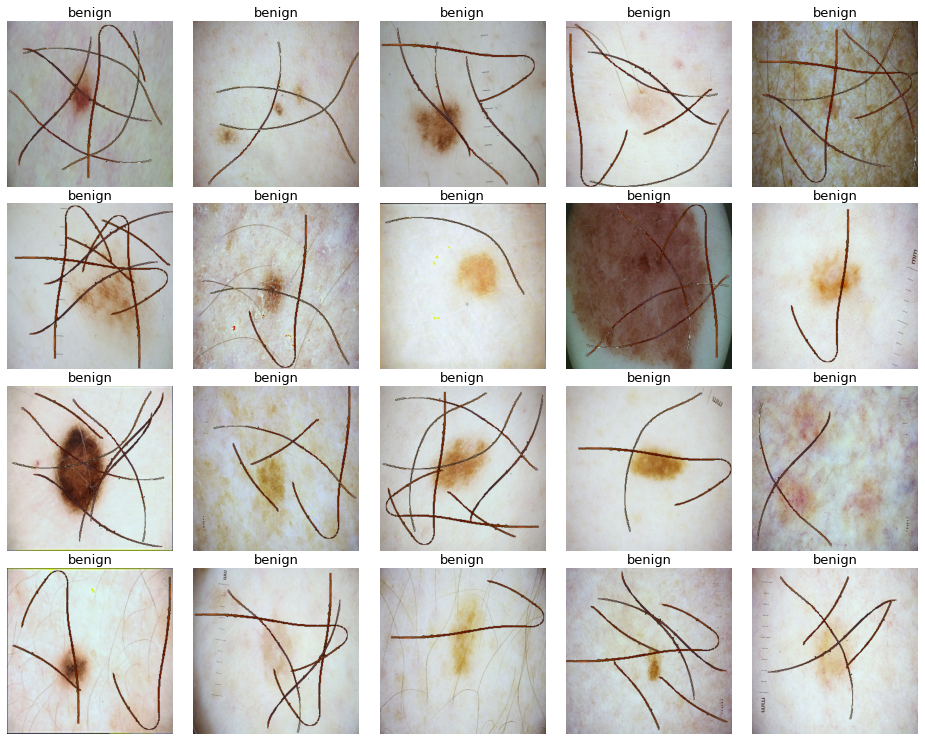

In [51]:
# run this cell again for next set of images
display_batch_of_images(next(train_batch))

In [52]:
del training_dataset, train_batch
gc.collect()

59717

In [53]:
# Peek at validation data

validation_dataset = validation_dataset.map(setup_input, num_parallel_calls=AUTO)
validation_dataset = get_validation_dataset(validation_dataset)
validation_dataset = validation_dataset.unbatch().batch(20)
validation_batch = iter(validation_dataset)

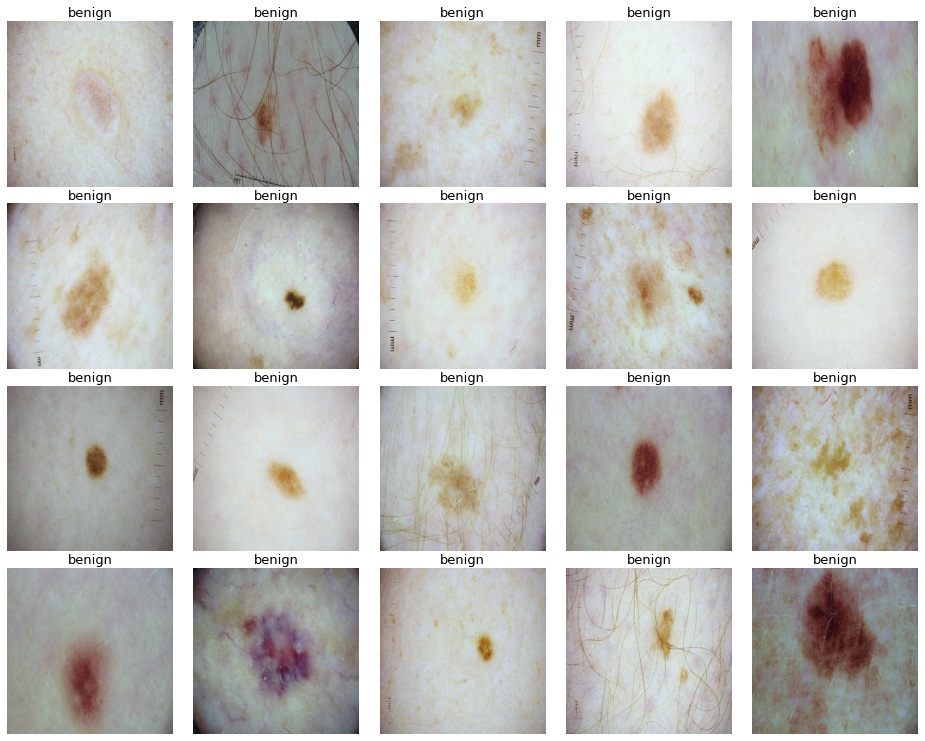

In [54]:
# run this cell again for next set of images
display_batch_of_images(next(validation_batch))

In [55]:
del validation_dataset, validation_batch
gc.collect()

40157

In [56]:
def setup_test_image(image, data):    
    tab_data=[tf.cast(data[tfeat], dtype=tf.float32) for tfeat in tab_feats]
    tabular=tf.stack(tab_data)

    return {'inp1': image, 'inp2': tabular}

In [57]:
def get_test_dataset(dataset):
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    
    return dataset

In [58]:
# peer at test data

test_dataset = load_dataset(TEST_FNAMES, labeled=False, ordered=True)
test_dataset = test_dataset.map(setup_test_image, num_parallel_calls=AUTO)
test_dataset = get_test_dataset(test_dataset)
test_dataset = test_dataset.unbatch().batch(20)
test_batch = iter(test_dataset)

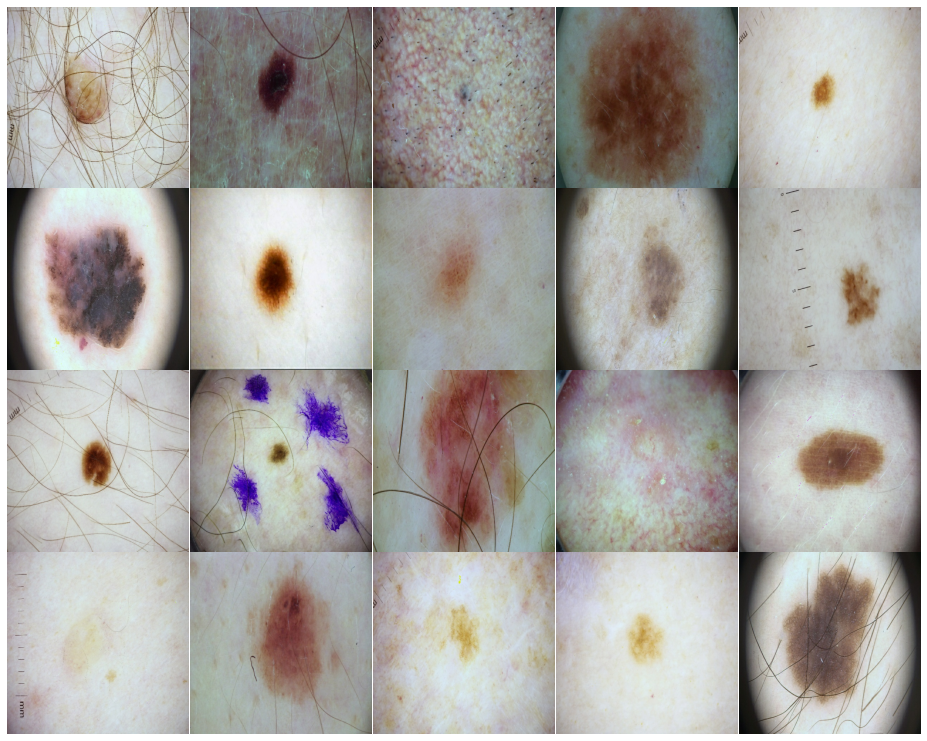

In [59]:
# run this cell again for next set of images
display_batch_of_images(next(test_batch), ds='test')

In [60]:
del test_dataset, test_batch
gc.collect()

43728

### Training

In [61]:
%%time

debug=0
    
histories = []

best_epoch={fn: np.zeros(NBEST) for fn in range(1, NFOLDS+1)}
best_score={fn: np.zeros(NBEST) for fn in range(1, NFOLDS+1)}

for fold_num in range(1, NFOLDS+1):
    
    tf.keras.backend.clear_session()
    # clear tpu memory (otherwise can run into Resource Exhausted Error)
    # see https://www.kaggle.com/c/flower-classification-with-tpus/discussion/131045
    tf.tpu.experimental.initialize_tpu_system(tpu)
    
    print("="*50)
    print(f"Starting fold {fold_num} out of {NFOLDS}...")
    
    files_trn=TRAIN_FNAMES[f"fold_{fold_num}"]
    files_val=VAL_FNAMES[f"fold_{fold_num}"]
    
    if debug:
        files_trn=files_trn[0:2]
        files_val=files_val[0:2]
        EPOCHS=3
       
    train_dataset = load_dataset(files_trn)
    train_dataset = train_dataset.map(setup_input, num_parallel_calls=AUTO)
    
    val_dataset = load_dataset(files_val, ordered = True)
    val_dataset = val_dataset.map(setup_input, num_parallel_calls=AUTO)
    
    model = get_model()
    
    STEPS_PER_EPOCH = count_data_items(files_trn) // BATCH_SIZE
    
    print(f'STEPS_PER_EPOCH = {STEPS_PER_EPOCH}')

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
    
    history = model.fit(get_training_dataset(train_dataset), 
                        steps_per_epoch=STEPS_PER_EPOCH, 
                        epochs=EPOCHS, 
                        callbacks=[lr_callback,
                                   save_best_n(fold_num, model),
                                   ],
                        validation_data=get_validation_dataset(val_dataset),
                        class_weight=class_weights,
                        verbose=2,
                       )
    
    idx_sorted=np.argsort(best_score[fold_num])
    best_score[fold_num]=np.array(best_score[fold_num])[idx_sorted]
    best_epoch[fold_num]=np.array(best_epoch[fold_num])[idx_sorted]

    print(f"\nFold {fold_num} is finished. The best epochs: {[int(best_epoch[fold_num][i]) for i in range(len(best_epoch[fold_num]))]}")
    print(f"The corresponding scores: {[round(best_score[fold_num][i], 5) for i in range(len(best_epoch[fold_num]))]}")

    histories.append(history)

Starting fold 1 out of 5...
STEPS_PER_EPOCH = 414

Epoch 00001: LearningRateScheduler reducing learning rate to 5e-06.
Epoch 1/10
414/414 - 178s - auc: 0.5030 - loss: 13.8502 - val_auc: 0.5748 - val_loss: 13.4752 - lr: 5.0000e-06

Epoch 00002: LearningRateScheduler reducing learning rate to 1.56e-05.
Epoch 2/10
414/414 - 141s - auc: 0.6441 - loss: 12.5256 - val_auc: 0.7405 - val_loss: 11.5359 - lr: 1.5600e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 2.62e-05.
Epoch 3/10
414/414 - 140s - auc: 0.7680 - loss: 10.1600 - val_auc: 0.8255 - val_loss: 8.8410 - lr: 2.6200e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 3.68e-05.
Epoch 4/10
414/414 - 144s - auc: 0.8131 - loss: 7.4536 - val_auc: 0.8493 - val_loss: 6.2037 - lr: 3.6800e-05

Epoch 00005: LearningRateScheduler reducing learning rate to 4.74e-05.
Epoch 5/10
414/414 - 153s - auc: 0.8541 - loss: 4.9724 - val_auc: 0.8632 - val_loss: 4.0682 - lr: 4.7400e-05

Epoch 00006: LearningRateScheduler reducin

### Visualization of training progress

In [62]:
def display_training_curves(fold_num, data):

    plt.figure(figsize=(10,5), facecolor='#F0F0F0')

    epochs=np.arange(1, EPOCHS+1)

    # AUC
    plt.plot(epochs, data['auc'], label='training auc', color='red')
    plt.plot(epochs, data['val_auc'], label='validation auc', color='orange')

    # Loss
    plt.plot(epochs, data['loss'], label='training loss', color='blue')    
    plt.plot(epochs, data['val_loss'], label='validation loss', color='green')

    # Best
    ls=['dotted', 'dashed', 'dashdot', 'solid'] # don't use more than 4 best epochs 
                                                # or make proper adjustments!
    for i in range(NBEST):
        plt.axvline(best_epoch[fold_num][i], 0, 
                    best_score[fold_num][i], linestyle=ls[i], 
                    color='black', label=f'AUC {best_score[fold_num][i]:.5f}')
    
    plt.title(f"Fold {fold_num}. The best epochs: {[int(best_epoch[fold_num][i]) for i in range(len(best_epoch[fold_num]))]}; the best AUC's: {[round(best_score[fold_num][i], 5) for i in range(len(best_epoch[fold_num]))]}.", 
              fontsize='14')
    plt.ylabel('Loss/AUC', fontsize='12')
    plt.xlabel('Epoch', fontsize='12')
    plt.ylim((0, 1))
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

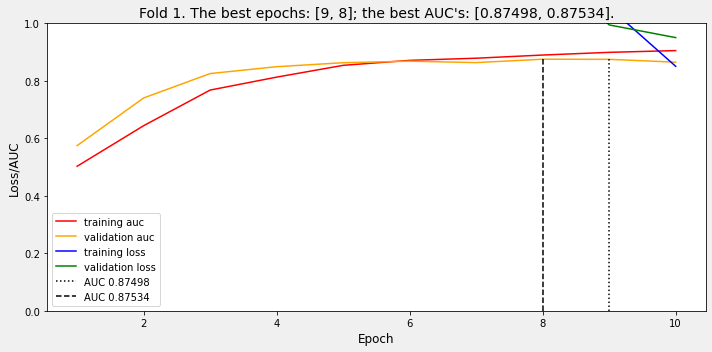

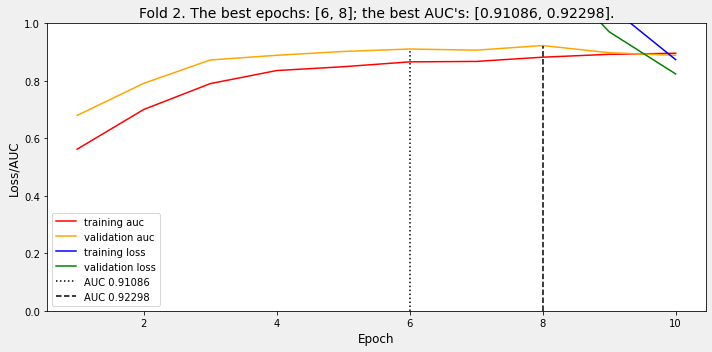

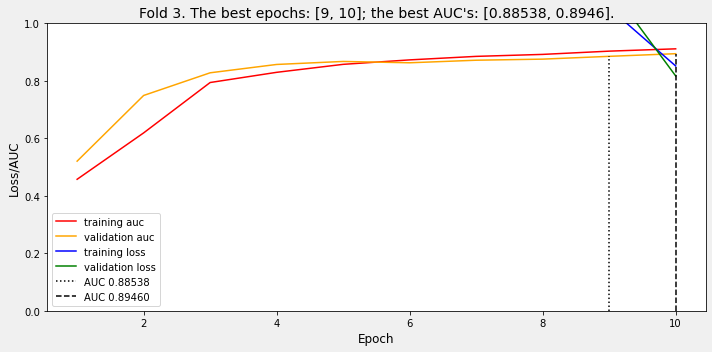

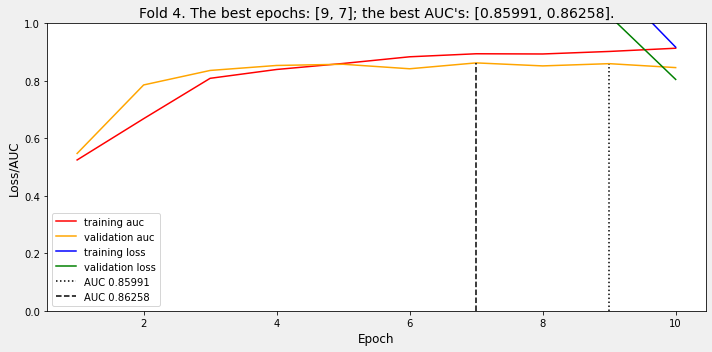

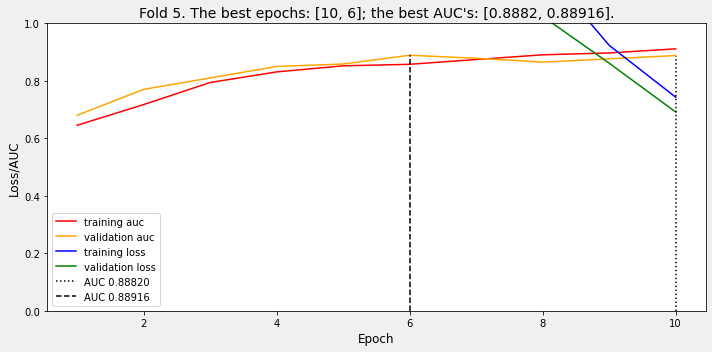

In [63]:
for fn in range(1, NFOLDS+1):
    display_training_curves(fn, data=histories[fn-1].history)

### Predictions

In [64]:
def setup_test_image(image, data):    
    tab_data=[tf.cast(data[tfeat], dtype=tf.float32) for tfeat in tab_feats]
    tabular=tf.stack(tab_data)

    return {'inp1': image, 'inp2': tabular}

In [65]:
def setup_test_name(image, data):
    return data['image_name']

In [66]:
def average_predictions(X, fn):
    
    y_probas=[]
    
    for idx in range(NBEST):
        
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        gc.collect()

        print(f"Predicting: fold {fn}, model {idx+1} out of {NBEST}...")

        with strategy.scope():
            path_best_model=f'best_model_fold_{fn}_{idx}.hdf5'
            model=tf.keras.models.load_model(SAVE_FOLDER/path_best_model)

        y=model.predict(X)
        y = rankdata(y)/len(y)
        y_probas.append(y)
    
    y_probas=np.average(y_probas, axis=0)

    return y_probas

In [67]:
%%time

preds = pd.DataFrame({'image_name': np.zeros(len(test)), 'target': np.zeros(len(test))})

test_ds = load_dataset(TEST_FNAMES, labeled=False, ordered=True)
test_images_ds = test_ds.map(setup_test_image, num_parallel_calls=AUTO)

test_images_ds = get_test_dataset(test_images_ds)
test_ds = get_test_dataset(test_ds)

test_ids_ds = test_ds.map(setup_test_name, num_parallel_calls=AUTO).unbatch()

preds['image_name'] = next(iter(test_ids_ds.batch(N_TEST_IMGS))).numpy().astype('U')
preds['target'] = np.average([average_predictions(test_images_ds, fn) for fn in range(1, NFOLDS+1)], axis = 0)

Predicting: fold 1, model 1 out of 2...
Predicting: fold 1, model 2 out of 2...
Predicting: fold 2, model 1 out of 2...
Predicting: fold 2, model 2 out of 2...
Predicting: fold 3, model 1 out of 2...
Predicting: fold 3, model 2 out of 2...
Predicting: fold 4, model 1 out of 2...
Predicting: fold 4, model 2 out of 2...
Predicting: fold 5, model 1 out of 2...
Predicting: fold 5, model 2 out of 2...
CPU times: user 7min 12s, sys: 1min 22s, total: 8min 35s
Wall time: 12min 59s


In [68]:
sub.head()

image_name  target
0  ISIC_0052060       0
1  ISIC_0052349       0
2  ISIC_0058510       0
3  ISIC_0073313       0
4  ISIC_0073502       0

In [69]:
del sub['target']
sub = sub.merge(preds, on='image_name')
sub.head()

image_name    target
0  ISIC_0052060  0.237115
1  ISIC_0052349  0.269377
2  ISIC_0058510  0.045156
3  ISIC_0073313  0.050123
4  ISIC_0073502  0.535895

In [70]:
print(f"The lengths of the submission file and `test` are {len(sub)} and {len(test)}, respectively.")
print(f"The number of NA's in the submission file is {sub.isna().sum().sum()}.")

The lengths of the submission file and `test` are 10982 and 10982, respectively.
The number of NA's in the submission file is 0.


In [71]:
if colab:
    OUT_FOLDER=SAVE_FOLDER
else:
    OUT_FOLDER=Path('')
    
sub.to_csv(OUT_FOLDER/'submission.csv', index=False)

### Out of fold predictions

In [72]:
def setup_val_image(image, label, data, label_name):
    
    tab_data=[tf.cast(data[tfeat], dtype=tf.float32) for tfeat in tab_feats]
    
    tabular=tf.stack(tab_data)

    return {'inp1': image, 'inp2': tabular}

In [73]:
def setup_val_name(image, label, data, label_name):
    return data['image_name']

In [74]:
def setup_val_label(image, label, data, label_name):
    return label

In [75]:
oof= pd.DataFrame({'image_name': train['image_name'].values})

auc=[]
oof_all_folds=[]

for fold_num in range(1, NFOLDS+1):
    
    tf.keras.backend.clear_session()
    
    print("="*50)
    print(f"Starting fold {fold_num}...")    

    print(f"The best epochs: {[int(best_epoch[fold_num][i]) for i in range(len(best_epoch[fold_num]))]}")
    print(f"The corresponding scores: {[round(best_score[fold_num][i], 5) for i in range(len(best_epoch[fold_num]))]}")

    files_val=VAL_FNAMES[f"fold_{fold_num}"]
    
    if debug:
        files_val=files_val[0:2]
    
    val_ds = load_dataset(files_val, ordered = True)
    val_images_ds = val_ds.map(setup_val_image,
                               num_parallel_calls=AUTO)
    val_images_ds = get_validation_dataset(val_images_ds)
        
    val_ds = get_validation_dataset(val_ds)

    val_label_ds = val_ds.map(setup_val_label,
                              num_parallel_calls=AUTO).unbatch()
    val_ids_ds = val_ds.map(setup_val_name,
                            num_parallel_calls=AUTO).unbatch()
    
    n_val_fold = count_data_items(files_val)
    
    print(f'The # of validation files = {n_val_fold}')    
    
    oof_fold= pd.DataFrame()
    
    oof_fold['image_name'] = next(iter(val_ids_ds.batch(n_val_fold))).numpy().astype('U')

    oof_fold['target'] = average_predictions(val_images_ds, fold_num)

    oof_all_folds.append(oof_fold)

    y_true = next(iter(val_label_ds.batch(n_val_fold))).numpy()

    auc_fold=roc_auc_score(y_true, oof_fold['target'].values)
    auc.append(auc_fold)
    
    print(f"Fold {fold_num} is done! ROC AUC = {auc_fold:.5f}")

oof=oof.merge(pd.concat(oof_all_folds), 
              on='image_name', 
              how='left').reset_index(drop=True)

if debug:
    oof=oof.fillna(0)

auc=np.array(auc)
auc_av=auc.mean()
auc_std=auc.std()

print(f"ROC AUC = {auc_av:.5f}, STDEV = {auc_std:.5f} (average across the folds)")

auc_oof=roc_auc_score(train['target'].values, oof['target'].values)

print(f"ROC AUC = {auc_oof:.5f} (out of folds)")

Starting fold 1...
The best epochs: [9, 8]
The corresponding scores: [0.87498, 0.87534]
The # of validation files = 6624
Predicting: fold 1, model 1 out of 2...
Predicting: fold 1, model 2 out of 2...
Fold 1 is done! ROC AUC = 0.87877
Starting fold 2...
The best epochs: [6, 8]
The corresponding scores: [0.91086, 0.92298]
The # of validation files = 6630
Predicting: fold 2, model 1 out of 2...
Predicting: fold 2, model 2 out of 2...
Fold 2 is done! ROC AUC = 0.92160
Starting fold 3...
The best epochs: [9, 10]
The corresponding scores: [0.88538, 0.8946]
The # of validation files = 6634
Predicting: fold 3, model 1 out of 2...
Predicting: fold 3, model 2 out of 2...
Fold 3 is done! ROC AUC = 0.89288
Starting fold 4...
The best epochs: [9, 7]
The corresponding scores: [0.85991, 0.86258]
The # of validation files = 6622
Predicting: fold 4, model 1 out of 2...
Predicting: fold 4, model 2 out of 2...
Fold 4 is done! ROC AUC = 0.86552
Starting fold 5...
The best epochs: [10, 6]
The correspondin

In [76]:
print(f"The lengths of the oof data frame and `train` are {len(oof)} and {len(train)}, respectively.")
print(f"The number of NA's in the oof data frame is {oof.isna().sum().sum()}.")

The lengths of the oof data frame and `train` are 33126 and 33126, respectively.
The number of NA's in the oof data frame is 0.


In [77]:
oof.to_csv(OUT_FOLDER/'oof.csv', index=False)

### ROC curve

In [78]:
del auc
gc.collect()

9711

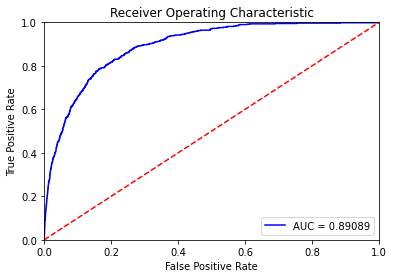

In [79]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(train['target'].values, oof['target'].values)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Sanity check

Finally, we will compute the correlation coefficient between our predictions for the test set and a similar predictions taken from Version 9 of this Kaggle notebook that scored 0.914 on the public leader board (model -- EfficientNet B0). This is just our sanity check.

In [80]:
sub_0914=pd.read_csv('/kaggle/input/siim-benchmark-submission/submission_LB_0.914.csv')

corr=np.corrcoef(rankdata(sub_0914['target'].values)/len(sub_0914), 
                 rankdata(sub['target'].values)/len(sub))

print(f"The correlation with the benchmark submission: \n {corr}.")

FileNotFoundError: [Errno 2] File /kaggle/input/siim-benchmark-submission/submission_LB_0.914.csv does not exist: '/kaggle/input/siim-benchmark-submission/submission_LB_0.914.csv'